In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(".."))

# Enable GPU training
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [8]:
from dynamical_systems.mass_spring_damper_system import MassSpringDamperEnv
from models.mc_dropout_bnn import MCDropoutBNN
from sampling_methods.random_exploration import random_exploration
from train import create_dataloader, train_model
from utils import combine_datasets

env = MassSpringDamperEnv(nlin=True, noise_var=0.01)

# Hyperparameters
NUM_TRAJECTORIES = 50
HORIZON = 500
BATCH_SIZE = 50
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
HIDDEN_SIZE = 64
DROP_PROB = 0.1

Epoch 10/10 Loss: 0.054493 Test: 0.001571: 100%|██████████| 500/500 [00:00<00:00, 552.79it/s]


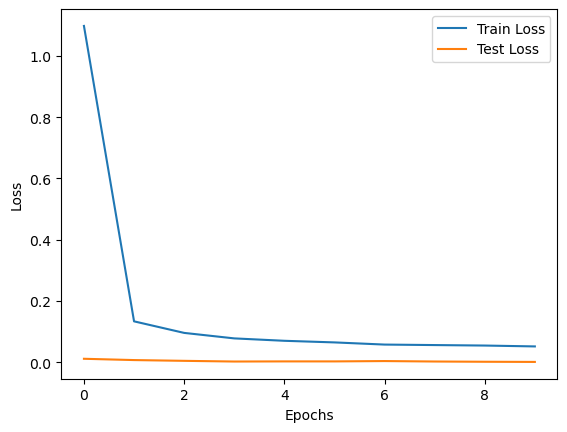

Model training completed successfully. Weights have been saved as 'mc_dropout_mass_spring_damper.pth' in the 'weights' directory.


In [9]:
# Collect data from the environment
train_dataset = random_exploration(env, HORIZON)
for _ in range(NUM_TRAJECTORIES-1):
    new_dataset = random_exploration(env, HORIZON)
    train_dataset = combine_datasets(train_dataset, new_dataset)
# Create DataLoader for training
train_dataloader = create_dataloader(train_dataset, BATCH_SIZE)
# Collect data for test set
test_dataset = random_exploration(env, HORIZON)
# Create DataLoader for training
test_dataloader = create_dataloader(test_dataset, HORIZON)

# Initialize the dynamics model
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
model = MCDropoutBNN(state_dim, action_dim, hidden_size=HIDDEN_SIZE, drop_prob=DROP_PROB, device=device)

# Train the model
train_model(model, train_dataloader, test_dataloader, NUM_EPOCHS, LEARNING_RATE, plot=True)

# Ensure the 'weights' directory exists
os.makedirs('../weights', exist_ok=True)

# Save the trained model
torch.save(model.model.state_dict(), '../weights/mc_dropout_mass_spring_damper.pth')
print("Model training completed successfully. "
      "Weights have been saved as 'mc_dropout_mass_spring_damper.pth' in the 'weights' directory.")

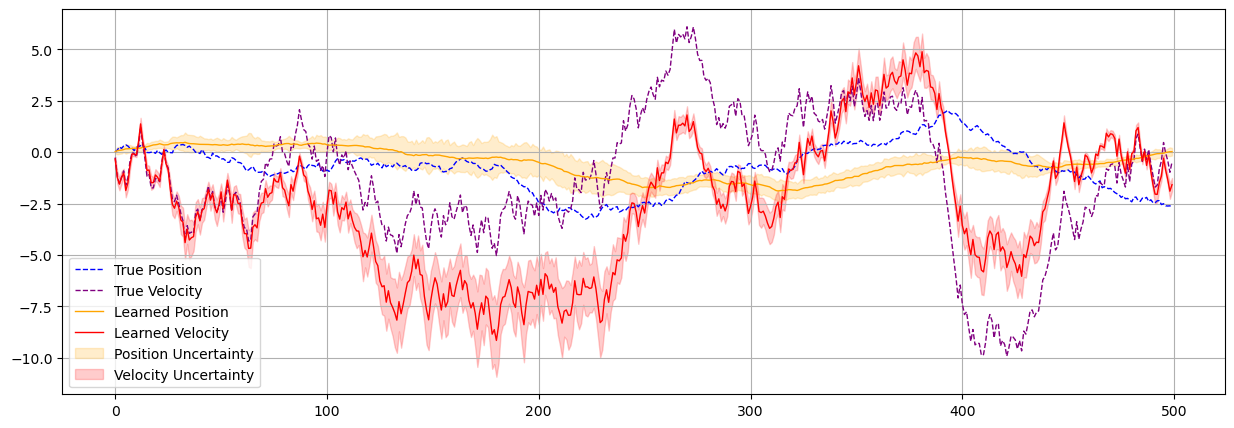

In [14]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(".."))

# test model
from dynamical_systems.mass_spring_damper_system import MassSpringDamperEnv

import numpy as np
import pygame
import matplotlib.pyplot as plt

# set random seed to get same test trajectory
test_seed = 44

env = MassSpringDamperEnv(nlin=True)
# Initialize trained dynamics model
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
trained_model = MCDropoutBNN(state_dim, action_dim, hidden_size=HIDDEN_SIZE, drop_prob=DROP_PROB)

# load saved weights
trained_model.load_state_dict(torch.load('../weights/mc_dropout_mass_spring_damper.pth'))

# learned dynamic
trained_env = MassSpringDamperEnv(model=trained_model)
trained_env.reset()
env.reset()
# env.action_space.seed(test_seed)
save = [[],[],[]]
save_var = []
# clock = pygame.time.Clock()
for _ in range(500):
    action = env.action_space.sample()
    obs, _, _, _, _ = env.step(action)
    save[0].append(obs)
    obs, _, _, _, info = trained_env.step(action)
    save[1].append(obs)
    save[2].append(np.sqrt(info['var']))
    # clock.tick(800)
trained_env.close()

saved_traj = np.array(save)
plt.figure(1, (15,5))
plt.plot(saved_traj[0,:,0], label="True Position", color="blue", linestyle="--", linewidth=1)
plt.plot(saved_traj[0,:,1], label="True Velocity", color="purple", linestyle="--", linewidth=1)
plt.plot(saved_traj[1,:,0], label="Learned Position", color="orange", linewidth=1)
plt.plot(saved_traj[1,:,1], label="Learned Velocity", color="red", linewidth=1)
scale_factor = 3.0
position_upper = saved_traj[1,:,0] + scale_factor*saved_traj[2,:,0]
position_lower = saved_traj[1,:,0] - scale_factor*saved_traj[2,:,0]
velocity_upper = saved_traj[1,:,1] + scale_factor*saved_traj[2,:,1]
velocity_lower = saved_traj[1,:,1] - scale_factor*saved_traj[2,:,1]
# plt.plot(saved_traj[2,:,0], label="Position Variance", color="green", linewidth=1)
# plt.plot(saved_traj[2,:,1], label="Velocity Variance", color="gray", linewidth=1)
plt.fill_between(np.arange(len(save[0])), position_lower, position_upper, color="orange", alpha=0.2, label="Position Uncertainty")
plt.fill_between(np.arange(len(save[0])), velocity_lower, velocity_upper, color="red", alpha=0.2, label="Velocity Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

Epoch 20/20 Loss: 0.130812 Test: 0.000000: 100%|██████████| 1000/1000 [00:04<00:00, 239.57it/s]


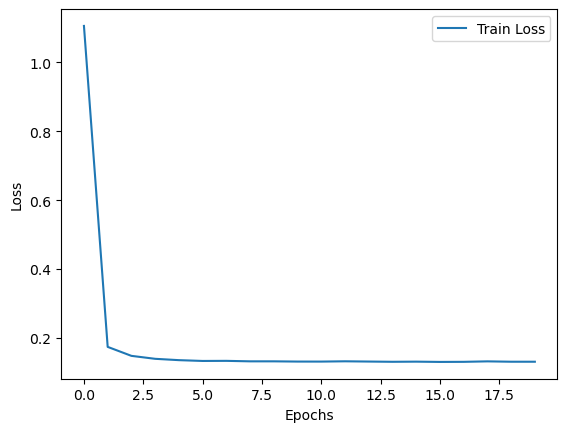

Epoch 20/20 Loss: 0.000049 Test: 0.000000: 100%|██████████| 1000/1000 [00:02<00:00, 401.63it/s]


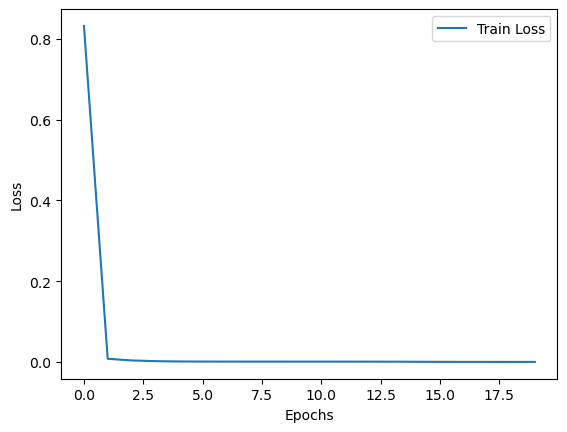

BNN OBSVERATION:  [ 0.00977788 -0.73774326]
FEEDFORWARD OBSERVATION:  [-0.00197441 -0.77067024]
BNN OBSVERATION:  [ 0.01902344 -0.28140557]
FEEDFORWARD OBSERVATION:  [-0.00941303 -0.28202876]
BNN OBSVERATION:  [ 0.02360043 -0.9358774 ]
FEEDFORWARD OBSERVATION:  [-0.01401538 -0.9717587 ]
BNN OBSVERATION:  [ 0.04022432 -0.44555   ]
FEEDFORWARD OBSERVATION:  [-0.02340782 -0.44170383]
BNN OBSVERATION:  [ 0.04446198 -0.89052635]
FEEDFORWARD OBSERVATION:  [-0.02925408 -0.91841704]
BNN OBSVERATION:  [ 0.06210145 -0.43987396]
FEEDFORWARD OBSERVATION:  [-0.0381702  -0.43013176]
BNN OBSVERATION:  [ 0.05983532 -0.90424526]
FEEDFORWARD OBSERVATION:  [-0.04389388 -0.91404253]
BNN OBSVERATION:  [ 0.07099403 -0.19389221]
FEEDFORWARD OBSERVATION:  [-0.05214832 -0.16365078]
BNN OBSVERATION:  [ 0.06858429 -0.8191365 ]
FEEDFORWARD OBSERVATION:  [-0.05548787 -0.81697494]
BNN OBSVERATION:  [ 0.0698058 -1.0492858]
FEEDFORWARD OBSERVATION:  [-0.06462324 -1.0553085 ]


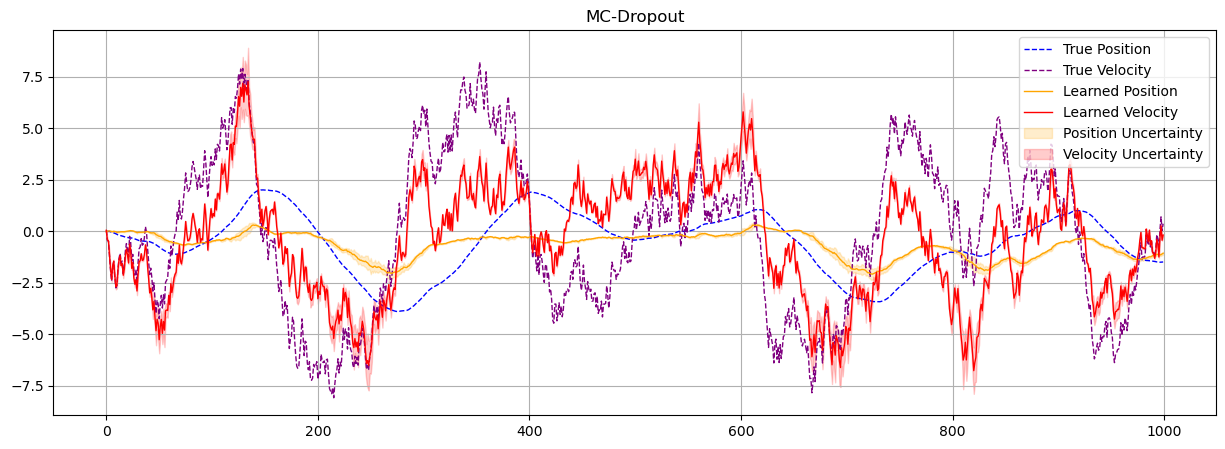

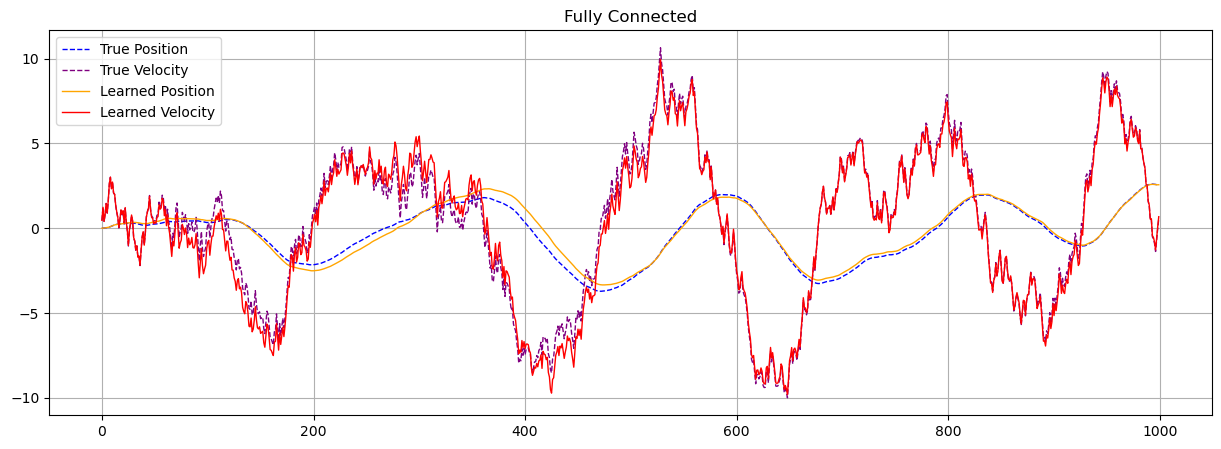

In [ ]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(".."))

from dynamical_systems.mass_spring_damper_system import MassSpringDamperEnv
from models.mc_dropout_bnn import MCDropoutBNN
from sampling_methods.random_exploration import random_exploration
from train import create_dataloader, train_model
from utils import combine_datasets

import torch
import os
import numpy as np
import pygame
import matplotlib.pyplot as plt

env = MassSpringDamperEnv(nlin=True)

# Hyperparameters
NUM_TRAJECTORIES = 200
HORIZON = 1000
BATCH_SIZE = 200
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
HIDDEN_SIZE = 32
DROP_PROB = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Collect data from the environment
train_dataset = random_exploration(env, HORIZON)
for _ in range(NUM_TRAJECTORIES-1):
    new_dataset = random_exploration(env, HORIZON)
    train_dataset = combine_datasets(train_dataset, new_dataset)
# Create DataLoader for training
train_dataloader = create_dataloader(train_dataset, BATCH_SIZE)

# Initialize the dynamics model
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
bnn_model = MCDropoutBNN(state_dim, action_dim, hidden_size=HIDDEN_SIZE, drop_prob=DROP_PROB, device=device)
ff_model = MCDropoutBNN(state_dim, action_dim, hidden_size=HIDDEN_SIZE, drop_prob=0)

bnn_env = MassSpringDamperEnv(model=bnn_model)
ff_env = MassSpringDamperEnv(model=ff_model)
bnn_env.reset()
ff_env.reset()
env.reset()

# Train the models
train_model(bnn_env.model, train_dataloader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE, plot=True)
train_model(ff_env.model, train_dataloader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE, plot=True)

for _ in range(10):
    action = env.action_space.sample()
    bnn_obs, _, _, _, info = bnn_env.step(action)
    ff_obs, _, _, _, info = ff_env.step(action)
    print("BNN OBSVERATION: ", bnn_obs)
    print("FEEDFORWARD OBSERVATION: ", ff_obs)

bnn_env.reset()
ff_env.reset()
env.reset()

bnn_save = [[],[],[]]
# clock = pygame.time.Clock()
for _ in range(1000):
    action = env.action_space.sample()
    obs, _, _, _, _ = env.step(action)
    bnn_save[0].append(obs)
    obs, _, _, _, info = bnn_env.step(action)
    bnn_save[1].append(obs)
    bnn_save[2].append(info['var'])
    # clock.tick(400)
bnn_env.close()

bnn_saved_traj = np.array(bnn_save)
plt.figure(1, (15,5))
plt.plot(bnn_saved_traj[0,:,0], label="True Position", color="blue", linestyle="--", linewidth=1)
plt.plot(bnn_saved_traj[0,:,1], label="True Velocity", color="purple", linestyle="--", linewidth=1)
plt.plot(bnn_saved_traj[1,:,0], label="Learned Position", color="orange", linewidth=1)
plt.plot(bnn_saved_traj[1,:,1], label="Learned Velocity", color="red", linewidth=1)
scale_factor = 3.0
position_upper = bnn_saved_traj[1,:,0] + scale_factor*bnn_saved_traj[2,:,0]
position_lower = bnn_saved_traj[1,:,0] - scale_factor*bnn_saved_traj[2,:,0]
velocity_upper = bnn_saved_traj[1,:,1] + scale_factor*bnn_saved_traj[2,:,1]
velocity_lower = bnn_saved_traj[1,:,1] - scale_factor*bnn_saved_traj[2,:,1]
# plt.plot(saved_traj[2,:,0], label="Position Variance", color="green", linewidth=1)
# plt.plot(saved_traj[2,:,1], label="Velocity Variance", color="gray", linewidth=1)
plt.fill_between(np.arange(len(bnn_save[0])), position_lower, position_upper, color="orange", alpha=0.2, label="Position Uncertainty")
plt.fill_between(np.arange(len(bnn_save[0])), velocity_lower, velocity_upper, color="red", alpha=0.2, label="Velocity Uncertainty")
plt.legend()
plt.grid(True)
plt.title("MC-Dropout")
plt.show()

bnn_env.reset()
ff_env.reset()
env.reset()

ff_save = [[],[]]
# clock = pygame.time.Clock()

ff_saved_traj = np.array(ff_save)
plt.figure(2, (15,5))
plt.plot(ff_saved_traj[0,:,0], label="True Position", color="blue", linestyle="--", linewidth=1)
plt.plot(ff_saved_traj[0,:,1], label="True Velocity", color="purple", linestyle="--", linewidth=1)
plt.plot(ff_saved_traj[1,:,0], label="Learned Position", color="orange", linewidth=1)
plt.plot(ff_saved_traj[1,:,1], label="Learned Velocity", color="red", linewidth=1)
plt.legend()
plt.grid(True)
plt.title("Fully Connected")
plt.show()